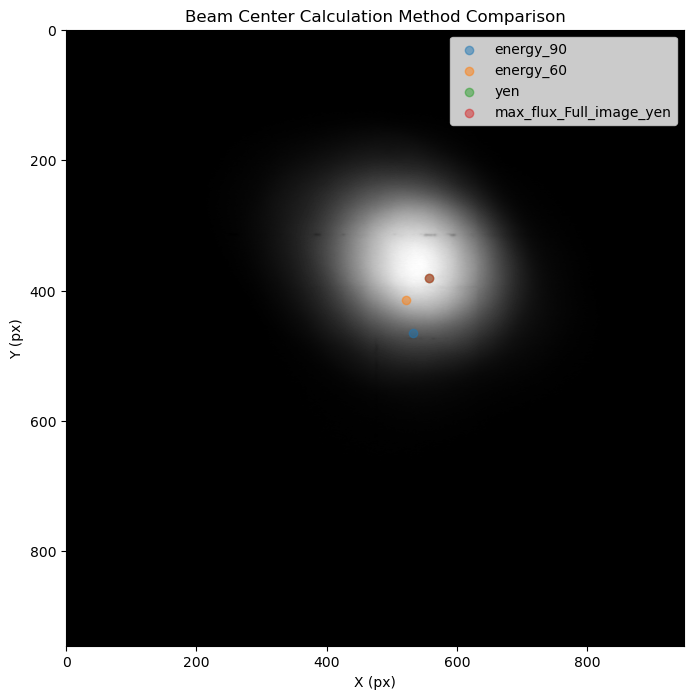

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
from skimage.filters import threshold_yen
from skimage.measure import label, regionprops


# image_folder = r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\PSA-CIEMAT\data\Test tracking H1605 to BCS people"
# image_file_name = "H1605 TRK 24-01-2025 Start_11.57.00 End_15.57.37 Frames-48 TFOV.tif"
image_folder = r"C:\Users\qzheng\Documents\Round Robin Test Images"
image_file_name = "RR_main_1.tif"
image_file_path = os.path.join(image_folder, image_file_name)
images = imread(image_file_path)



# image_0 = images[0]
image_0 = images
img_offset = 300 # Adjust the image to remove background noise

x_scale = 12 / image_0.shape[1]
y_scale = 12 / image_0.shape[0]

# target_x_low = 183
# target_x_high = 1150
# target_y_low = 27
# target_y_high = 991

image_0_uint = image_0.copy()
image_0_int = image_0_uint.copy().astype(np.int32)
image_0_int_offset = image_0_int - img_offset
image_0_int_offset[image_0_int_offset < 0] = 0
image_0_int_offset = image_0_int_offset.astype(np.uint16)
image_0 = image_0_int_offset.copy()



centroid_file = os.path.join(os.getcwd(), "results", "BCS_RR_on_timestamp_1.csv")
centroid_df = pd.read_csv(centroid_file, index_col=0)

beam_center_calculation_method = ["energy_90", "energy_60", "yen", "max_flux_Full_image_yen"]
x_column_name = "Beam Center X (px)"
y_column_name = "Beam Center Y (px)"

plt.figure(figsize=(8, 8))
plt.imshow(image_0, cmap="gray")
x_center_buffer = []
y_center_buffer = []
for method in beam_center_calculation_method:
    full_method_name = f"centroid_Full_image_{method}" if method != "max_flux_Full_image_yen" else "centroid_Full_image_yen"
    x_val = centroid_df.loc[full_method_name, x_column_name]
    y_val = centroid_df.loc[full_method_name, y_column_name]
    plt.scatter(x_val, y_val, label=method, alpha=0.5)
    x_center_buffer.append(x_val)
    y_center_buffer.append(y_val)

plt.title("Beam Center Calculation Method Comparison")
plt.xlabel("X (px)")
plt.ylabel("Y (px)")
plt.legend()
plt.show()







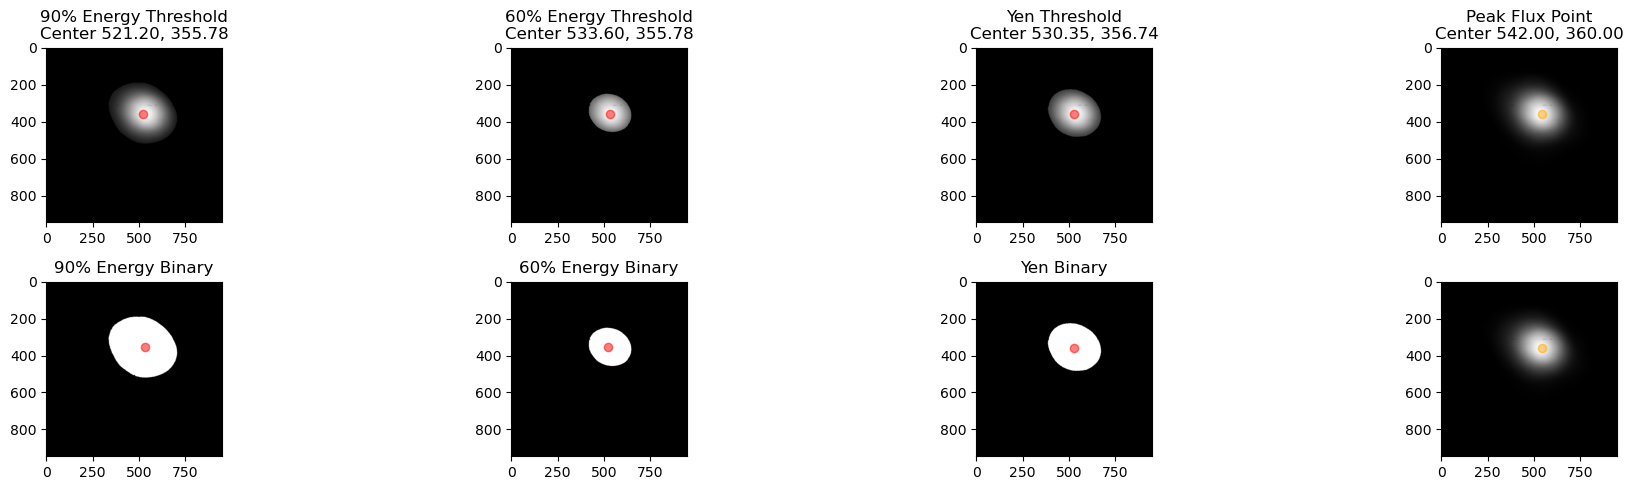

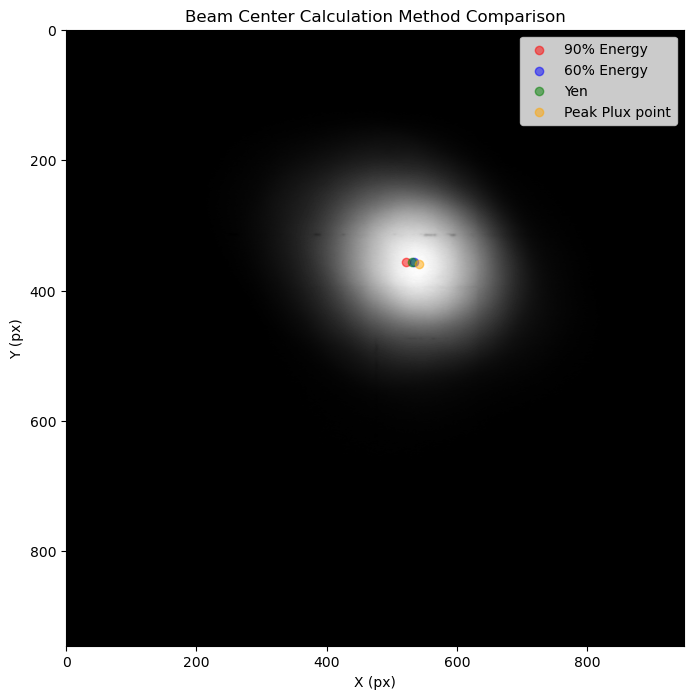

In [6]:
def find_theshold_with_energy(img_input, energy_level):
    sorted_data = np.sort(img_input.flatten())[::-1]
    cumulative_sum = np.cumsum(sorted_data)
    total_sum = cumulative_sum[-1]
    threshold_index = np.searchsorted(cumulative_sum, total_sum * energy_level / 100.0)
    threshold_value = sorted_data[threshold_index]
    return threshold_value

def find_centroid(img_input, bright_spot_threshold):
    regionprops_list = regionprops(label(img_input > bright_spot_threshold), 
                                            intensity_image=img_input)
    sorted_regionprops = sorted(regionprops_list, key=lambda x: x.area, reverse=True)

    beam_center_pixel = sorted_regionprops[0].centroid
    return beam_center_pixel

threshold_yen = threshold_yen(image_0)
threshold_90 = find_theshold_with_energy(image_0, 90)
threshold_60 = find_theshold_with_energy(image_0, 60)

img_threshold_90_binary = image_0 > threshold_90
img_threshold_60_binary = image_0 > threshold_60
img_threshold_yen_binary = image_0 > threshold_yen
img_threhsold_90 = image_0.copy()
img_threhsold_90[~img_threshold_90_binary] = 0
img_threhsold_90_center = find_centroid(image_0, threshold_90)
img_threhsold_60 = image_0.copy()
img_threhsold_60[~img_threshold_60_binary] = 0
img_threhsold_60_center = find_centroid(image_0, threshold_60)
img_threshold_yen = image_0.copy()
img_threshold_yen[~img_threshold_yen_binary] = 0
img_threshold_yen_center = find_centroid(image_0, threshold_yen)

img_max_val = np.max(image_0)
(y_max, x_max) = np.where(image_0 == img_max_val)
y_max = y_max[0]
x_max = x_max[0]




fig, ax = plt.subplots(2, 4, figsize=(20, 5))
ax[0, 0].imshow(img_threhsold_90, cmap="gray")
ax[0, 0].scatter(img_threhsold_90_center[1], img_threhsold_90_center[0], label="90% Energy", color="red", alpha=0.5)
ax[0, 0].set_title(f"90% Energy Threshold\nCenter {img_threhsold_90_center[1]:.2f}, {img_threhsold_90_center[0]:.2f}")
ax[0, 1].imshow(img_threhsold_60, cmap="gray")
ax[0, 1].scatter(img_threhsold_60_center[1],img_threhsold_60_center[0], label="60% Energy", color="red", alpha=0.5)
ax[0, 1].set_title(f"60% Energy Threshold\nCenter {img_threhsold_60_center[1]:.2f}, {img_threhsold_60_center[0]:.2f}")
ax[1, 0].imshow(img_threshold_90_binary, cmap="gray")
ax[1, 0].scatter(img_threhsold_60_center[1],img_threhsold_60_center[0], label="90% Energy Binary", color="red", alpha=0.5)
ax[1, 0].set_title("90% Energy Binary")
ax[1, 1].imshow(img_threshold_60_binary, cmap="gray")
ax[1, 1].scatter(img_threhsold_90_center[1], img_threhsold_90_center[0], label="60% Energy Binary", color="red", alpha=0.5)
ax[1, 1].set_title("60% Energy Binary")
ax[0, 2].imshow(img_threshold_yen, cmap="gray")
ax[0, 2].scatter(img_threshold_yen_center[1], img_threshold_yen_center[0], label="Yen Threshold", color="red", alpha=0.5)
ax[0, 2].set_title(f"Yen Threshold\nCenter {img_threshold_yen_center[1]:.2f}, {img_threshold_yen_center[0]:.2f}")
ax[1, 2].imshow(img_threshold_yen_binary, cmap="gray")
ax[1, 2].scatter(img_threshold_yen_center[1], img_threshold_yen_center[0], label="Yen Binary", color="red", alpha=0.5)
ax[1, 2].set_title("Yen Binary")
ax[0, 3].imshow(image_0, cmap="gray")
ax[0, 3].scatter(x_max, y_max, label="Peak Plux point", color="orange", alpha=0.5)
ax[0, 3].set_title(f"Peak Flux Point\nCenter {x_max:.2f}, {y_max:.2f}")
ax[1, 3].imshow(image_0, cmap="gray")
ax[1, 3].scatter(x_max, y_max, label="Peak Plux point", color="orange", alpha=0.5)    

plt.tight_layout()
plt.show()



plt.figure(figsize=(8, 8))
plt.imshow(image_0, cmap="gray")
plt.scatter(img_threhsold_90_center[1], img_threhsold_90_center[0], label="90% Energy", color="red", alpha=0.5)
plt.scatter(img_threhsold_60_center[1], img_threhsold_60_center[0], label="60% Energy", color="blue", alpha=0.5)
plt.scatter(img_threshold_yen_center[1], img_threshold_yen_center[0], label="Yen", color="green", alpha=0.5)
plt.scatter(x_max, y_max, label="Peak Plux point", color="orange", alpha=0.5)
plt.title("Beam Center Calculation Method Comparison")
plt.xlabel("X (px)")
plt.ylabel("Y (px)")
plt.legend()
plt.show()


In [9]:
def calculate_azimuth_and_elevation_error(ideal_vector, actual_vector):
    """
    Calculate the azimuth and elevation errors between two 3D vectors.

    Args:
        ideal_vector (numpy.ndarray): Ideal pointing vector (3D).
        actual_vector (numpy.ndarray): Actual pointing vector (3D).

    Returns:
        tuple: (azimuth_error, elevation_error) in radians.
    """
    # Normalize the vectors
    ideal_vector = ideal_vector / np.linalg.norm(ideal_vector)
    actual_vector = actual_vector / np.linalg.norm(actual_vector)

    # Calculate azimuth angles (in radians)
    ideal_azimuth = np.arctan2(ideal_vector[1], ideal_vector[0])
    actual_azimuth = np.arctan2(actual_vector[1], actual_vector[0])
    azimuth_error = actual_azimuth - ideal_azimuth

    # Calculate elevation angles (in radians)
    ideal_elevation = np.arcsin(ideal_vector[2])
    actual_elevation = np.arcsin(actual_vector[2])
    elevation_error = actual_elevation - ideal_elevation

    return azimuth_error*1000, elevation_error*1000


# generate a pandas dataframe
x_center = image_0.shape[1] / 2
y_center = image_0.shape[0] / 2

beam_x_center_px_buffer = [img_threhsold_90_center[1], img_threhsold_60_center[1], img_threshold_yen_center[1], x_max]
beam_y_center_px_buffer = [img_threhsold_90_center[0], img_threhsold_60_center[0], img_threshold_yen_center[0], y_max]
x_center_meter = (np.array(beam_x_center_px_buffer) - x_center) * x_scale
y_center_meter = -(np.array(beam_y_center_px_buffer) - y_center) * y_scale

x_aim_meter = 1
y_aim_meter = 1.5

heliostat_pos = np.array([-44.386, 259.001, 3.5 + 3.925])
target_center_pos = np.array([-0.008, 6.524, 34.165])
aiming_point = np.array([-x_aim_meter, 0.0, y_aim_meter])

ideal_pointing_vector = target_center_pos + aiming_point - heliostat_pos

beam_center_transformed = np.array([-x_center_meter, np.zeros_like(x_center_meter),  y_center_meter])
actual_pointing_vector = target_center_pos[:, np.newaxis] + beam_center_transformed - heliostat_pos[:, np.newaxis]

azimuth_error_buffer = []
elevation_error_buffer = []

for i in range(len(beam_x_center_px_buffer)):
    azimuth_error, elevation_error = calculate_azimuth_and_elevation_error(ideal_pointing_vector, actual_pointing_vector[:, i])
    azimuth_error_buffer.append(azimuth_error)
    elevation_error_buffer.append(elevation_error)

azimuth_error_desired, elevation_error_desired = calculate_azimuth_and_elevation_error(ideal_pointing_vector, ideal_pointing_vector)
azimuth_error_buffer.append(azimuth_error_desired)
elevation_error_buffer.append(elevation_error_desired)

column_names = ["Method", "X (px)", "Y (px)", "X (m)", "Y (m)", "Azimuth Error (mrad)", "Elevation Error (mrad)"]
data = {
    "Method": ["90% Energy", "60% Energy", "Yen", "Peak Flux", "Desired"],
    "X (px)": np.append(beam_x_center_px_buffer, x_aim_meter / x_scale + x_center),
    "Y (px)": np.append(beam_y_center_px_buffer, -(y_aim_meter  / y_scale) + y_center),
    "X (m)": np.append(x_center_meter, x_aim_meter),
    "Y (m)": np.append(y_center_meter, y_aim_meter),
    "Azimuth Error (mrad)": azimuth_error_buffer,
    "Elevation Error (mrad)": elevation_error_buffer
}
df = pd.DataFrame(data)
# round all values to int
df["X (px)"] = df["X (px)"].round().astype(int)
df["Y (px)"] = df["Y (px)"].round().astype(int)
df["X (m)"] = df["X (m)"].round(3).astype(float)
df["Y (m)"] = df["Y (m)"].round(3).astype(float)
df["Azimuth Error (mrad)"] = df["Azimuth Error (mrad)"].round(3).astype(float)
df["Elevation Error (mrad)"] = df["Elevation Error (mrad)"].round(3).astype(float)


df.set_index("Method", inplace=True)

# Set display options
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)  # Set the display width
pd.set_option("display.float_format", "{:.3f}".format)  # Format floats to 3 decimal places

# Print the DataFrame
print(df)

            X (px)  Y (px)  X (m)  Y (m)  Azimuth Error (mrad)  Elevation Error (mrad)
Method                                                                                
90% Energy     521     356  0.591  1.487                 1.575                  -0.080
60% Energy     534     356  0.747  1.487                 0.972                  -0.069
Yen            530     357  0.706  1.475                 1.130                  -0.119
Peak Flux      542     360  0.854  1.433                 0.563                  -0.267
Desired        554     355  1.000  1.500                 0.000                   0.000
